<center><h1> Assignment 0 (Background & Warmup) </h1>
<h3>Due 9PM Monday 29 January, 2024</h3></center>


This assignment is designed to confirm your background knowledge in the fundamentals of Linear Algebra, Probability, and Fully-connected Neural Networks. All the imports made in this notebook are as below; if these imports work, you are (mostly) set to complete the assignment. You are encouraged to read/view optional materials as needed, and some information was provided in the recent programming review.

Note: Wherever possible, avoid using in-built functions and demonstrate that you know what is going on behind the scenes.

In [ ]:
import numpy as np
import requests
import io

import torch
import torch.nn.functional as f

<table>
  <tr>
    <td>**Section**</td>
    <td>**Score**</td>
  </tr>
  <tr>
    <td> Multivariate Gaussians <br> [Q1 + Q2 + Q3] </td>
    <td> 3 + 3 + 4 </td>
  </tr>
  <tr>
    <td> Invertible Neural Network <br> [Q1 forward + Q2 invert + Q3 trace estimator] </td>
    <td> 2 + 5 + 6</td>
  </tr>
    <tr>
    <td> Logistic Regression </td>
    <td> 3 </td>
  </tr>
  <tr>
    <td> **Total**  </td>
    <td> **26** </td>
  </tr>
  </table>

# I. Multivariate Gaussians

In the following, we will refer to the matrix $\mathbf{A}_{M\times M}$ and the column vectors $\mathbf{y}_{M\times 1}$, $\mathbf{x}_{M\times 1}$ and $\mu_{M\times 1}$.


[Q1] If $\mathbf{y} = \mathbf{A}\mathbf{x} + \mu$ and $\mathbf{x} \sim N(0,I_M)$ show that:

1. $\mathbb{E}[\mathbf{y}]=\mu$
2. $\mathbb{E}[\left(\mathbf{y-\mu}\right)\left(\mathbf{y-\mu}\right)^\top]=\mathbf{A}\mathbf{A}^\top$.

[Q2] Fill out the following functions for confirming the above.

In [ ]:
# Fill out these functions

def E_y(ys:np.array):
    """
    ys: A batch of column vectors
    return: Mean of the column vectors
    """
    return np.mean(ys, axis=0)

def E_yyT(ys:np.array):
    """
    ys: A batch of column vectors
    return: Covariance matrix of the column vectors
    """

    return np.mean(ys@ys.transpose(0, 2, 1), axis=0) #ys=y-mu

In [ ]:
# Code to test the above two functions.

M=2

# Observe how the matrix shapes are adjusted to allow for the vectorization.
A = np.random.randint(low=1,high=10,size=(1,M,M))
xs = np.random.randn(50000,M,1)
mu = np.random.randint(low=0,high=10,size=(1,M,1))

ys = A @ xs + mu

# The following two column-vectors should be nearly identical
print("Mean:")
print(E_y(ys))
print(mu,end="\n\n")

# The following two matrices should be nearly identical
print("Covariance:")
print(E_yyT(ys-mu))
print(A[0]@A[0].T)


Mean:
[[9.02331263]
 [1.01963886]]
[[[9]
  [1]]]

Covariance:
[[60.38661088 48.53126818]
 [48.53126818 40.63281023]]
[[61 49]
 [49 41]]


[Q3] Given a covariance matrix $\mathbf{C}$ and mean $\mu$, generate N samples of $y$ using $\mathbf{x} \sim N(0, I_m)$ such that $\mathbb{E}[\mathbf{y}]=\mu$
and $\mathbb{E}[\left(\mathbf{y-\mu}\right)\left(\mathbf{y-\mu}\right)^\top]=\mathbf{C}$.

Hint: See np.linalg.cholesky

In [ ]:
def sample(C, mu, N):
    """
    C: An MxM "positive definite"(?!?!) symmetric matrix
    mu: An Mx1 column vector
    return: A batch of column-vectors with Mean=mu and Covariance=C
    """
    M = C.shape[0]

    # cholesky decomposition of C
    L = np.linalg.cholesky(C)

    # standard normal distribution
    x = np.random.standard_normal(size=(1,M,N))

    # apply the formula y = L@x+mu where C=L@L.T
    y = (L @ x) + mu.reshape(-1,1)
    y = y.T #return transpose

    return y

In [ ]:
# Code to test the above function

M = 5

# The following ensures that C is a positive semi-definite symmetric matrix. Find out why! What happens if low=0?
A = np.random.randint(low=1,high=10,size=(M,M))
A[np.triu_indices(M,k=1)] = 0

C = A@A.T

mu = np.random.randint(low=0,high=10,size=(1,M,1))

ys = sample(C, mu, 50000)

# The following two column-vectors should be nearly identical
print("Mean:")
print(E_y(ys))
print(mu,end="\n\n")

# The following two matrices should be nearly identical
print("Covariance:")
print(E_yyT(ys-mu))
print(C)

Mean:
[[0.02642202]
 [8.98006373]
 [9.01963137]
 [9.03122831]
 [6.0063428 ]]
[[[0]
  [9]
  [9]
  [9]
  [6]]]

Covariance:
[[ 24.98879364  30.14658917  40.16292841  45.17475376   5.21067577]
 [ 30.14658917 117.47080655 111.66055906 126.25383467  60.62909218]
 [ 40.16292841 111.66055906 129.71938389 140.72124522  74.69604476]
 [ 45.17475376 126.25383467 140.72124522 203.95056972  96.96838729]
 [  5.21067577  60.62909218  74.69604476  96.96838729  98.48177514]]
[[ 25  30  40  45   5]
 [ 30 117 111 126  60]
 [ 40 111 129 140  74]
 [ 45 126 140 203  96]
 [  5  60  74  96  98]]


# II. Invertible Neural Network

Invertible neural networks -- which learn bijective (invertible) functions $f$ such that if $y=f(x)$, we should be  able to obtain an unique $x=f^{-1}(y)$ -- play a central role in many applications. In this assignment, we will work with invertible fully-connected 3-Layer Neural Networks.

Recall that the main operation in neural networks is matrix multiplication and in order to compute the inverse, we would need to invert the matrices. As computing inverse is costly, we store each matrix in their SVD factorized forms $W = USV$, where U and V are orthogonal matrices and S is diagonal [with none of the diagonal entries being 0]. Also, observe that the number of hidden units at all layers are equal to the number of input units (why?!).

In this assignment, we will use parameters of an "already-invertible" neural network and just write the code for computing the forward and inversion operations.

Q1. Write the code for forward pass, by choosing "LeakyReLU" as the activation function with negative_slope=0.1.

Q2. Subsequently, write the code for the invert function.

In [ ]:
import torch.nn.functional as F

class InvertibleNN(torch.nn.Module):
    def __init__(self, m):

        super(InvertibleNN,self).__init__()

        self.u1 = torch.nn.Parameter(torch.nn.init.normal_(torch.empty(m,m)))
        self.s1 = torch.nn.Parameter(torch.nn.init.normal_(torch.empty(m,m)))
        self.v1 = torch.nn.Parameter(torch.nn.init.normal_(torch.empty(m,m)))
        self.b1 = torch.nn.Parameter(torch.nn.init.normal_(torch.empty(m)))

        self.u2 = torch.nn.Parameter(torch.nn.init.normal_(torch.empty(m,m)))
        self.s2 = torch.nn.Parameter(torch.nn.init.normal_(torch.empty(m,m)))
        self.v2 = torch.nn.Parameter(torch.nn.init.normal_(torch.empty(m,m)))
        self.b2 = torch.nn.Parameter(torch.nn.init.normal_(torch.empty(m)))

        self.u3 = torch.nn.Parameter(torch.nn.init.normal_(torch.empty(m,m)))
        self.s3 = torch.nn.Parameter(torch.nn.init.normal_(torch.empty(m,m)))
        self.v3 = torch.nn.Parameter(torch.nn.init.normal_(torch.empty(m,m)))
        self.b3 = torch.nn.Parameter(torch.nn.init.normal_(torch.empty(m)))

    def forward(self, x):
        """
        x: A batch input of shape (N,m)
        return: The output of the fully-connected 3-layer neural network
        """

        # Write code here
        u1, s1, v1, b1 = self.u1, self.s1, self.v1, self.b1
        u2, s2, v2, b2 = self.u2, self.s2, self.v2, self.b2
        u3, s3, v3, b3 = self.u3, self.s3, self.v3, self.b3

        #calculate weights using W=USV.T
        w1 = u1 @ s1 @ v1.T
        w2 = u2 @ s2 @ v2.T
        w3 = u3 @ s3 @ v3.T

        #forward pass operations
        z1 = x @ w1 + b1
        o1 = F.leaky_relu(z1, negative_slope=0.1)

        z2 = o1 @ w2 + b2
        o2 = F.leaky_relu(z2, negative_slope=0.1)

        z3 = o2 @ w3 + b3
        o3 = F.leaky_relu(z3, negative_slope=0.1)
        y = o3 #returning output

        return y

    def invert(self, y):
        """
        y: A batch input of shape (N,m)
        return: The input of the fully-connected 3-layer neural network which would yield y
        """

        # Write code here
        u1, s1, v1, b1 = self.u1, self.s1, self.v1, self.b1
        u2, s2, v2, b2 = self.u2, self.s2, self.v2, self.b2
        u3, s3, v3, b3 = self.u3, self.s3, self.v3, self.b3

        # winverse using W.inv = VS.invU.T
        w3inv = v3 @ torch.inverse(s3) @ u3.T
        w2inv = v2 @ torch.inverse(s2) @ u2.T
        w1inv = v1 @ torch.inverse(s1) @ u1.T

        #inverse function operations
        o3 = F.leaky_relu(y, negative_slope=10)
        z3 = (o3-b3)@w3inv
        o2 = F.leaky_relu(z3, negative_slope=10)
        z2 = (o2-b2)@w2inv
        o1 = F.leaky_relu(z2, negative_slope=10)
        z1 = (o1-b1)@w1inv
        x = z1 #returning input

        return x


In [ ]:
# Code to test the forward and invert functions

for m in range(1,11): # change back to 11
    iNN = InvertibleNN(m)

    r = requests.get("https://web.cs.dal.ca/~sastry/inv_net_{}.pt".format(m))
    iNN.load_state_dict(torch.load(io.BytesIO(r.content)))

    x = torch.FloatTensor(np.random.randint(low=1,high=10,size=(1,m)))

    # These 2 outputs should be nearly identical.
    print(x)
    print(iNN.invert(iNN(x)))

    print("="*40)

tensor([[1.]])
tensor([[1.0000]], grad_fn=<MmBackward0>)
tensor([[9., 7.]])
tensor([[9.0000, 7.0000]], grad_fn=<MmBackward0>)
tensor([[1., 4., 3.]])
tensor([[1.0000, 4.0000, 3.0000]], grad_fn=<MmBackward0>)
tensor([[3., 6., 5., 4.]])
tensor([[3.0000, 6.0001, 5.0001, 3.9998]], grad_fn=<MmBackward0>)
tensor([[1., 1., 3., 4., 3.]])
tensor([[1.0001, 1.0001, 2.9999, 4.0000, 3.0000]], grad_fn=<MmBackward0>)
tensor([[5., 6., 6., 9., 2., 8.]])
tensor([[5.0000, 6.0000, 6.0000, 9.0000, 2.0000, 8.0000]],
       grad_fn=<MmBackward0>)
tensor([[7., 7., 1., 1., 7., 3., 1.]])
tensor([[7.0004, 7.0001, 1.0001, 1.0000, 6.9999, 2.9996, 0.9999]],
       grad_fn=<MmBackward0>)
tensor([[4., 5., 8., 7., 3., 6., 3., 7.]])
tensor([[4.0001, 5.0000, 8.0001, 7.0001, 3.0000, 6.0001, 3.0000, 7.0001]],
       grad_fn=<MmBackward0>)
tensor([[3., 7., 3., 5., 3., 3., 2., 1., 2.]])
tensor([[3.0000, 7.0000, 3.0002, 4.9999, 2.9999, 3.0000, 2.0000, 1.0000, 2.0000]],
       grad_fn=<MmBackward0>)
tensor([[5., 3., 2., 6., 7.

Q3. In certain applications, it is important to calculate the trace of the input-output Jacobian matrix. Shown below is the code for computing the trace of the input-output jacobian. In general, for an N-dimensional input, we would require N `backward` passes [which can easily blow up in real-world settings]. However, we can reduce the number of backward passes by using the Huchtinson's trick:

$$tr(A)=\mathbb{E}_{x}[x^\top A x]$$

where $x$ is a random variable such that $\mathbb{E}[xx^\top] = I$. Popular choices are Rademacher and Gaussian Distributions.

Mathematically prove that Hutchinson's trick works, i.e., that the equation above holds. Can you use the Hutchinson's trick to estimate the trace of the input-output Jacobian? Your output should be almost identical to the exact trace for the suggested configuration of the Neural Network.

In [ ]:
def exact_trace(iNN,x):
    x.requires_grad = True
    y = iNN(x)
    sum = 0
    for i in range(x.shape[1]):
        sum += torch.autograd.grad(y[0,i],x,retain_graph=True)[0][0,i]
    return sum

def approximate_trace(iNN,x):
  x.requires_grad = True
  y = iNN(x)

  # generate z using Rademacher distribution
  z = 2 * torch.randint(0, 2, (1, x.shape[1]), device=x.device).float() - 1

  # trace using JVP and Hutchinson's trick
  jvp = torch.autograd.grad(y, x, z, retain_graph=True)[0] * x.shape[1] # and reshape
  product = z * jvp
  trace = torch.mean(product) #expectation

  return trace.mean()

iNN = InvertibleNN(1000)

r = requests.get("https://web.cs.dal.ca/~sastry/inv_net_1000.pt")
iNN.load_state_dict(torch.load(io.BytesIO(r.content)))

for i in range(10):
    x = torch.FloatTensor(np.random.randn(1,1000))
    print(exact_trace(iNN,x))
    print(approximate_trace(iNN,x))
    print("="*30)

tensor(9.6033e+08)
tensor(9.6033e+08)
tensor(1.1440e+09)
tensor(1.1440e+09)
tensor(1.0704e+09)
tensor(1.0704e+09)
tensor(1.1099e+09)
tensor(1.1099e+09)
tensor(9.1867e+08)
tensor(9.1867e+08)
tensor(1.1302e+09)
tensor(1.1302e+09)
tensor(1.1474e+09)
tensor(1.1474e+09)
tensor(1.2160e+09)
tensor(1.2160e+09)
tensor(1.2111e+09)
tensor(1.2111e+09)
tensor(1.0307e+09)
tensor(1.0307e+09)


# III. Logistic Regression

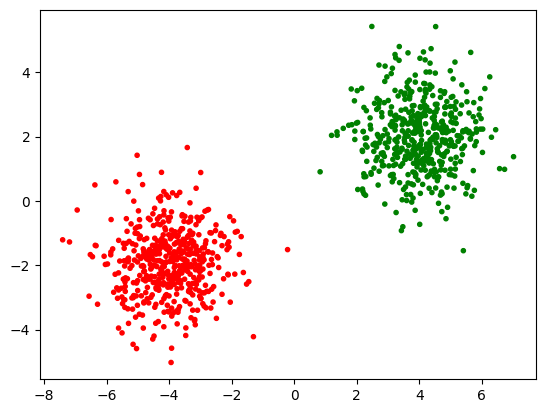

In [ ]:
%matplotlib inline
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from matplotlib.pyplot import xlim

# Create linearly separable data
x,y = make_blobs(n_samples=1000, n_features=2, centers=[[-4,-2],[4,2]], cluster_std=1, shuffle=True)
colors = np.array(['red','green'])
plt.scatter(x[:, 0], x[:, 1],
            color = colors[y].tolist(), marker='.')
xmin, xmax = xlim()

In [ ]:
class LogisticRegression(torch.nn.Module):
    def __init__(self,input_dimensions):
        super(LogisticRegression, self).__init__()

        # Define trainable parameters
        self.w = torch.nn.Parameter(torch.randn(input_dimensions,1))
        self.b = torch.nn.Parameter(torch.zeros(1))

    def train(self,X,Y):
        """
        X: a numpy array of shape [*, input_dimensions]
        Y: a numpy array of shape [*,1]
        """
        print('shape of w,b', self.w.shape,self.b.shape)
        X = torch.tensor(X,dtype=torch.float32)# Create Tensor from numpy array
        Y = torch.tensor(Y,dtype=torch.float32)# Create Tensor from numpy array
        print('X,Y',X.shape,Y.shape)

        print("Training...")

        optim = torch.optim.SGD(self.parameters(), lr=0.1) #sending parameters

        for i in range(50):
            z = X@self.w + self.b
            pred = torch.sigmoid(z).squeeze() # Apply the weights on the inputs and get the prediction

            cost = -Y*torch.log(pred)-(1-Y)*torch.log(1-pred) # Compute the Cross-entropy loss using pred and Y.
            cost = torch.mean(cost) #scalar cost for backward grad

            reg = (0.001/2)*(torch.sum(torch.square(self.w))) # L2 regularization with lambda = 0.001

            optim.zero_grad()
            cost.backward()
            reg.backward()
            optim.step()

        print(cost)

shape of w,b torch.Size([2, 1]) torch.Size([1])
X,Y torch.Size([1000, 2]) torch.Size([1000])
Training...
tensor(0.0148, grad_fn=<MeanBackward0>)


/usr/local/lib/python3.10/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.10/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


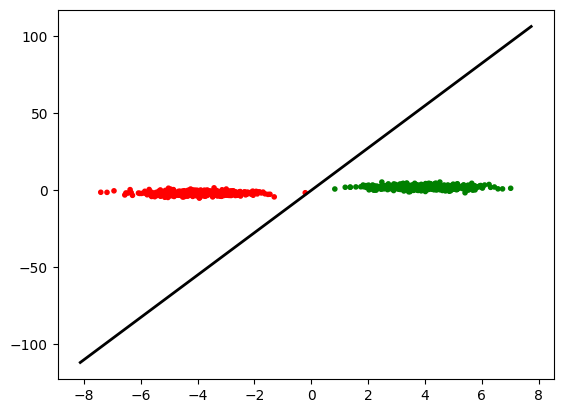

In [ ]:
lg = LogisticRegression(input_dimensions=2)
lg.train(x,y)
w,b = lg.w.detach(), lg.b.detach() # detach() for plotting

plt.scatter(x[:, 0], x[:, 1],
            color = colors[y].tolist(), marker='.')
xmin, xmax = xlim()

ymin = -(b+w[0][0]*xmin)/w[1][0]
ymax = -(b+w[0][0]*xmax)/w[1][0]

plt.plot([xmin,xmax],[ymin,ymax], color="black", linestyle='-', linewidth=2)